In [10]:
import pandas as pd
import numpy as np
import torch
import os
import random
import sys
from pathlib import Path
sys.path.append(str(Path('../../').resolve()))
from fastai.vision.all import *
from experiment_specific_utils import data_module, transforms
from utils import convnext

seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")
metadata

indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1

selected_channels = [0,3,4,5,6]
model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 256
batch_size=32
max_epochs=10
lr = 0.0004
train_transform = transforms.train_transform(reshape_size, include_normalization=False)
test_val_transform = None # Doesn't matter here, we only need train preprocessing to calculate stats

synapse_formation_module = data_module.SynapseFormationDataModule(metadata, train_index, validation_index, test_index, label_map, selected_channels, train_transform,
                                                test_val_transform, test_val_transform, batch_size, reshape_size)

synapse_formation_module.setup(stage='fit')
train_loader = synapse_formation_module.train_dataloader()
val_loader = synapse_formation_module.val_dataloader()
dls = DataLoaders(train_loader, val_loader)

/var/tmp/ipykernel_1253174/3714781660.py:21: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")


Initializing datasets...
Datasets initialized successfully!


In [11]:
model = convnext.ConvnextModel(num_classes=len(set_of_interesting_classes), in_chans=len(selected_channels), learning_rate = lr, max_epochs = max_epochs, steps_per_epoch = len(train_loader))

/home/jedrzej/projects/image_flow_cytometry_fine_tune/.venv/lib/python3.10/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (log) that exists in the learner. Use `self.learn.log` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


/home/jedrzej/projects/image_flow_cytometry_fine_tune/.venv/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.lo

SuggestedLRs(valley=4.365158383734524e-05)

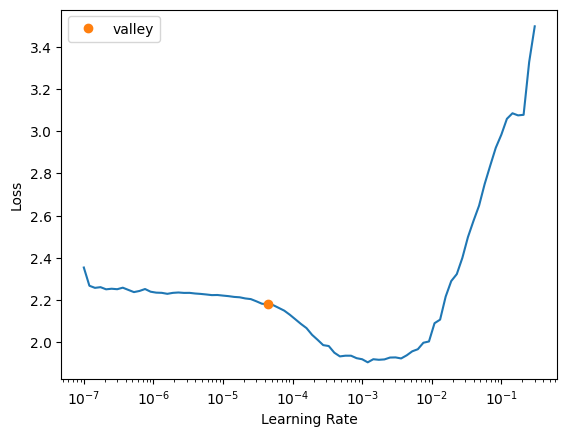

: 

In [ ]:
torch.cuda.empty_cache()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])
learn.lr_find()